In [ ]:
!git clone https://github.com/LINKS-Foundation-CPE/Master-QCC-2022-2023.git

In [ ]:
!pip install networkx 
!pip install matplotlib
!pip install osmnx
!pip install requests
!pip install dwave_qbsolv
!pip install pyyaml
!pip install scipy

In [ ]:
%cd /content/Master-QCC-2022-2023/

In [1]:
import sys
import osmnx as ox
import random
from datetime import datetime

In [2]:
#Create graph from name

city = "Recanati"
nation = "Italy"
nameofplace = city+', '+nation

G = ox.graph_from_place(nameofplace, network_type="drive", simplify=True)
ox.io.save_graphml(G, filepath= "city_graphs/" + city + "_" + nation + '.graphml')

In [2]:
#Load graph. N.B.:Only if graph already saved
city = "Recanati"
nation = "Italy"
G = ox.io.load_graphml("city_graphs/" + city + "_" + nation + '.graphml')

In [3]:
#Generate start and dest node (in a distance range). Generate alternative paths.

from src.best_path.compute_paths import *

NumberOfCars = 3
n_list = []
dist = 0
while dist > 3000. or dist < 1000:
    nodes = random.sample(G.nodes, 2)
    couple = (nodes[0], nodes[1])
    path = ox.distance.shortest_path(G, nodes[0], nodes[1], weight='length')
    dist = sum(ox.utils_graph.get_route_edge_attributes(G, path, "length"))
    
#couple = (2321173688, 356796548) #Recanati (297814054, 2195734221)
couple = (484013256, 4436427332)
for i in range(NumberOfCars):
    NumberOfRoutes = 3
    print(datetime.now(), " -> compute_paths")
    n_list.append(compute_paths(G, couple, NumberOfRoutes))

/var/folders/qp/68cmb73d6897nh_qdb2y19fr0000gn/T/ipykernel_3116/3903309149.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes = random.sample(G.nodes, 2)


2023-04-26 10:50:05.818535  -> compute_paths
2023-04-26 10:50:05.818642  -> start, end nodes' IDs =  (484013256, 4436427332)
2023-04-26 10:50:06.366789  -> k_shortest DONE
2023-04-26 10:50:06.367583  -> Jaccard indexes computation DONE
[0.11627906976744186, 0.11904761904761904, 0.11904761904761904, 0.11904761904761904, 0.12195121951219512, 0.12195121951219512, 0.12195121951219512, 0.12195121951219512, 0.125, 0.125, 0.1282051282051282, 0.1282051282051282, 0.13157894736842105, 0.15789473684210525, 0.1590909090909091, 0.16216216216216217, 0.17073170731707318, 0.175, 0.2727272727272727, 0.27906976744186046, 0.3, 0.3076923076923077, 0.5384615384615384, 0.6521739130434783, 0.7083333333333334, 0.7272727272727273, 0.7391304347826086, 0.8260869565217391, 0.95]
2023-04-26 10:50:06.367668  -> extraction of most different paths DONE
2023-04-26 10:50:06.367682  -> compute_paths
2023-04-26 10:50:06.367689  -> start, end nodes' IDs =  (484013256, 4436427332)
2023-04-26 10:50:06.867685  -> k_shortest 

/Users/giacomovitali/opt/anaconda3/envs/best_path_py39/lib/python3.9/site-packages/osmnx/plot.py:297: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


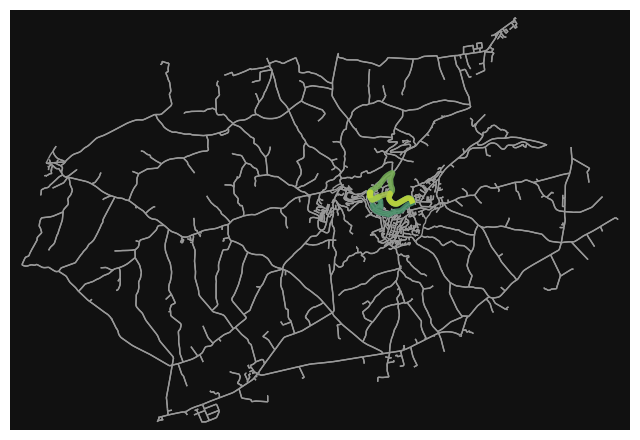

In [4]:
#Print generated paths

import itertools

flat_list = list(itertools.chain(*n_list))
for i in range(len(flat_list)):
    node_list = [flat_list[i][0][0]]
    node_list.extend([nodes[1] for nodes in flat_list[i]])
    flat_list[i] = node_list
fig, ax = ox.plot_graph_routes(
    G, routes=flat_list, route_colors=ox.plot.get_colors(n=len(flat_list)), route_linewidth=1, node_size=0, orig_dest_size = 1
)
fig.savefig("test.png", format='png', dpi=1800)

In [5]:
#Generate QUBO matrix

from src.best_path.Build_QUBO import *

#initialize data
info_list = []
k = 0
for list in n_list:
    car_routes = []
    for j in range(len(list)):
        car_routes.append({'route': list[j], 'var_num': k})
        k = k+1
    info_list.append(car_routes)
#calculate QUBO matrix
QUBOdict = GenerateQUBOmatrix_(G, info_list)

{"metadata":null,"data":null,"error":{"code":"user_disabled","title":"User has been disabled","detail":"User permissions have been revoked, contact Breezometer's admin at support@breezometer.com to enable"}}
Please check your API key validity


In [12]:
#Solve QUBO

from src.best_path.Solve_QUBO import *

numberOfRoutes = []
route_list =[]
routesDict = {}
for i, car in enumerate(info_list):
    route_list.extend([route['route'] for route in car])
    numberOfRoutes.append(len(car))
    for route in car:
        routesDict[route['var_num']] = i
print(routesDict)
solutionRoutes, energy, chosenRoutes = SolveQUBO(False, QUBOdict, route_list, numberOfRoutes, routesDict) #Bool for Classic or Quantum exec. Need to update src/guild.yml with working cred
print(solutionRoutes)
print(energy)
print(chosenRoutes)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2}
[(7, [(484013256, 484013195), (484013195, 484013193), (484013193, 484013183), (484013183, 2707684191), (2707684191, 1041919141), (1041919141, 1413592434), (1413592434, 1413592551), (1413592551, 484013147), (484013147, 484013139), (484013139, 4723122827), (4723122827, 297811891), (297811891, 4723122832), (4723122832, 4723122831), (4723122831, 297811890), (297811890, 297811886), (297811886, 297811885), (297811885, 5592616183), (5592616183, 297811881), (297811881, 5593220816), (5593220816, 5343003896), (5343003896, 1413592297), (1413592297, 297811877), (297811877, 1692756933), (1692756933, 4436427338), (4436427338, 4436427332)]), (5, [(484013256, 484013195), (484013195, 484013193), (484013193, 534574780), (534574780, 534574781), (534574781, 5438237039), (5438237039, 534574647), (534574647, 1041919150), (1041919150, 5522611881), (5522611881, 534574646), (534574646, 5522611880), (5522611880, 5438237046), (5438237046, 1413591925), (14135

[(484013256, 484013195), (484013195, 484013193), (484013193, 484013183), (484013183, 2707684191), (2707684191, 1041919141), (1041919141, 1413592434), (1413592434, 1413592551), (1413592551, 484013147), (484013147, 484013139), (484013139, 4723122827), (4723122827, 297811891), (297811891, 4723122832), (4723122832, 4723122831), (4723122831, 297811890), (297811890, 297811886), (297811886, 297811885), (297811885, 5592616183), (5592616183, 297811881), (297811881, 5593220816), (5593220816, 5343003896), (5343003896, 1413592297), (1413592297, 297811877), (297811877, 1692756933), (1692756933, 4436427338), (4436427338, 4436427332)]
[(484013256, 484013195), (484013195, 484013193), (484013193, 534574780), (534574780, 534574781), (534574781, 5438237039), (5438237039, 534574647), (534574647, 1041919150), (1041919150, 5522611881), (5522611881, 534574646), (534574646, 5522611880), (5522611880, 5438237046), (5438237046, 1413591925), (1413591925, 5403944161), (5403944161, 4074275050), (4074275050, 2978125

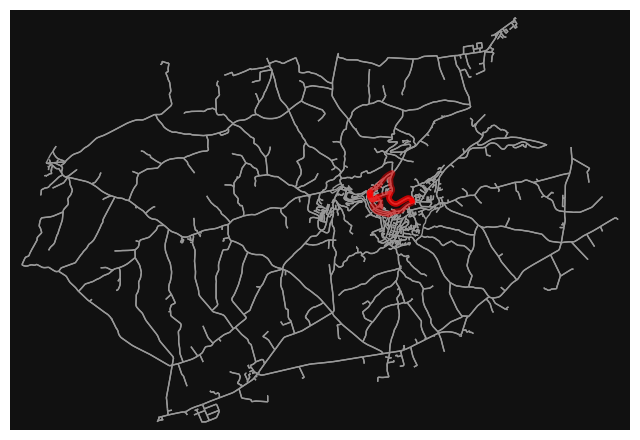

In [15]:

#show graph and colored solutions

plot_routes = []
colors = []
#for index, route in enumerate(route_list):
#    #generate a set from the node list
#    node_list = []
#    node_list.append(route[0][0])
#    node_list.extend([nodes[1] for nodes in route])
#    plot_routes.append(node_list)
#    colors.append((0.0, 0.0, 1.0, 0.1))
#    #colors.append('blue')
for index, route in enumerate([key[1] for key in solutionRoutes]):
    #generate a set from the node list
    node_list = []
    node_list.append(route[0][0])
    node_list.extend([nodes[1] for nodes in route])
    plot_routes.append(node_list)
    colors.append('red')
fig, ax = ox.plot_graph_routes(G, plot_routes, route_colors = colors, route_linewidth=6, node_size=0, orig_dest_size = 10, show = True)
fig.savefig('Solution_'+ city + "_" + nation + '.png', format='png', dpi=1800)